In [50]:
#import packages

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
import seaborn as sea

In [51]:
# read input files

train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv')

In [52]:
train.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [53]:
train.isna().sum()

store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

<Axes: >

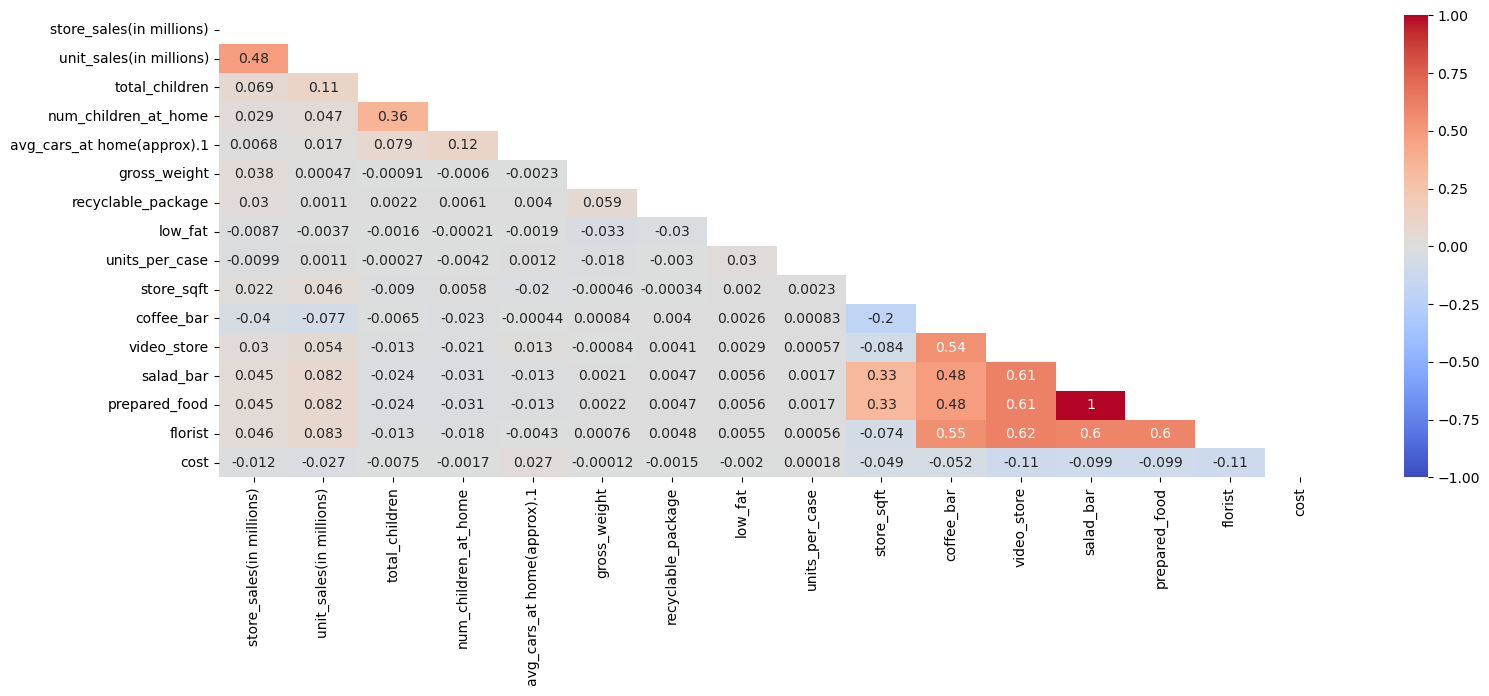

In [54]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(18, 6))
sea.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [55]:
x_train = train.drop(["cost", "prepared_food"], axis=1)
x_test = test.drop(["id", "prepared_food"], axis=1)

y_train = train[["cost"]]

In [56]:
y_train = np.log1p(y_train)

**Checking Accuracies without Feature Engineering**

In [57]:
models = {
    "xgb" : XGBRegressor(tree_method="gpu_hist"),
    "cat_boost" : CatBoostRegressor(verbose=0, task_type="GPU",
                           devices='0:1'),
    "linear_regression" : LinearRegression(),
    "ridge" : Ridge()
}  

In [58]:
scores = []
for model_name, model in models.items():
    fold_scores = cross_val_score(model, x_train, y_train['cost'], cv=5, scoring='neg_root_mean_squared_error', n_jobs = -1)
    scores.append({
        'model' : model_name,
        'score' : np.mean(fold_scores)
    })  

df = pd.DataFrame(scores, columns = ['model', 'score'])
df

/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif 

,model,score
0,xgb,-0.298587
1,cat_boost,-0.298359
2,linear_regression,-0.313397
3,ridge,-0.313397


**Checking Accuracies with Feature Engineering**

In [62]:
columns = x_train.columns
print("Unique values:")
for f in columns:
    print(f"{f:26} {np.unique(train[f])}")

Unique values:
store_sales(in millions)   [ 0.51  0.52  0.53 ... 20.6  22.16 22.92]
unit_sales(in millions)    [1. 2. 3. 4. 5. 6.]
total_children             [0. 1. 2. 3. 4. 5.]
num_children_at_home       [0. 1. 2. 3. 4. 5.]
avg_cars_at home(approx).1 [0. 1. 2. 3. 4.]
gross_weight               [ 6.    6.03  6.04  6.06  6.09  6.11  6.12  6.13  6.14  6.15  6.16  6.18
  6.19  6.2   6.21  6.23  6.26  6.27  6.29  6.3   6.31  6.32  6.33  6.35
  6.38  6.4   6.41  6.42  6.43  6.44  6.49  6.5   6.51  6.59  6.6   6.63
  6.66  6.68  6.72  6.73  6.74  6.75  6.76  6.78  6.79  6.8   6.81  6.82
  6.83  6.84  6.86  6.87  6.88  6.89  6.91  6.94  6.95  6.96  6.97  6.98
  6.99  7.03  7.04  7.06  7.07  7.09  7.1   7.11  7.12  7.13  7.14  7.17
  7.18  7.19  7.2   7.22  7.24  7.26  7.27  7.28  7.29  7.31  7.32  7.33
  7.36  7.38  7.39  7.41  7.42  7.43  7.47  7.48  7.49  7.5   7.54  7.55
  7.57  7.61  7.62  7.63  7.64  7.65  7.66  7.67  7.7   7.71  7.72  7.74
  7.77  7.79  7.8   7.86  7.87  7.88  7.9   7.9

In [63]:
columns = columns.drop("gross_weight")

In [64]:
print("Unique values:")
for f in columns:
    print(f"{f:26} {np.unique(train[f])}")

Unique values:
store_sales(in millions)   [ 0.51  0.52  0.53 ... 20.6  22.16 22.92]
unit_sales(in millions)    [1. 2. 3. 4. 5. 6.]
total_children             [0. 1. 2. 3. 4. 5.]
num_children_at_home       [0. 1. 2. 3. 4. 5.]
avg_cars_at home(approx).1 [0. 1. 2. 3. 4.]
recyclable_package         [0. 1.]
low_fat                    [0. 1.]
units_per_case             [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.]
store_sqft                 [20319. 21215. 22478. 23112. 23593. 23598. 23688. 23759. 24597. 27694.
 28206. 30268. 30584. 30797. 33858. 34452. 34791. 36509. 38382. 39696.]
coffee_bar                 [0. 1.]
video_store                [0. 1.]
salad_bar                  [0. 1.]
florist                    [0. 1.]


In [65]:
x_train['store_options'] = x_train[['coffee_bar', 'video_store', 'salad_bar', 'florist']].sum(axis=1)
x_test['store_options'] = x_test[['coffee_bar', 'video_store', 'salad_bar', 'florist']].sum(axis=1)

In [66]:
x_train["children_ratio"] = x_train["total_children"]/x_train["num_children_at_home"]
x_train["children_ratio"] = x_train["children_ratio"].replace([np.inf, -np.inf], 10)
x_train = x_train.fillna(0)

x_test["children_ratio"] = x_test["total_children"]/x_test["num_children_at_home"]
x_test["children_ratio"] = x_test["children_ratio"].replace([np.inf, -np.inf], 10)
x_test = x_test.fillna(0)

In [67]:
x_train["units_per_sqft"] = x_train["unit_sales(in millions)"]/x_train["store_sqft"]

x_test["units_per_sqft"] = x_test["unit_sales(in millions)"]/x_test["store_sqft"]

In [68]:
x_train.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,florist,store_options,children_ratio,units_per_sqft
id,,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000082
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,1.0,10.0,0.000071
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000189
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,1.0,10.0,0.000141
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,4.0,10.0,0.000108


In [69]:
models = {
    "xgb" : XGBRegressor(tree_method="gpu_hist"),
    "cat_boost" : CatBoostRegressor(verbose=0, task_type="GPU",
                           devices='0:1')
}   

In [70]:
scores = []
for model_name, model in models.items():
    fold_scores = cross_val_score(model, x_train, y_train['cost'], cv=5, scoring='neg_root_mean_squared_error', n_jobs = -1)
    scores.append({
        'model' : model_name,
        'score' : np.mean(fold_scores)
    })  

df = pd.DataFrame(scores, columns = ['model', 'score'])
df

/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

,model,score
0,xgb,-0.298307
1,cat_boost,-0.298291
2,linear_regression,-0.313351
3,ridge,-0.313397


In [71]:
model_data = { 
    'xgb' : {
        'model':XGBRegressor(tree_method="gpu_hist"),
        'params' : {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6],
            'min_child_weight': [1, 2, 3, 4],
            'gamma': [0, 0.1, 0.2, 0.3]
        }
    },
    'cat_boost' : {
        'model': CatBoostRegressor(verbose=0, task_type="GPU",
                           devices='0:1'),
        'params' : {
            'iterations': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'depth': [4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7]
        }
    }
}

In [72]:
accuracy_scores = []

for model_name, model_info in model_data.items():
    clf = RandomizedSearchCV(
        estimator = model_info['model'],
        param_distributions = model_info['params'], 
        cv = 5,
        n_iter = 50,
        verbose = 2,
        n_jobs = -1,
        scoring="neg_root_mean_squared_error"
    )
    clf.fit(x_train, y_train['cost'])
    accuracy_scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=100; total time=  18.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=100; total time=  18.9s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=100; total time=  19.0s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=100; total time=  19.1s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=100; total time=  19.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100; total time=  29.5s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100; total time=  29.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100; total time=  29.8s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100; total time=  29.8s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100; total time=  29.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=  54.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=  54.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=  54.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=  54.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=  54.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=300; total time= 1.3min
[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  26.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  26.3s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  26.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  26.7s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=  26.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=  18.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=  18.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=  18.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=  18.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=  18.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=200; total time=  33.0s
[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=200; total time=  32.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=200; total time=  32.8s
[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=200; total time=  33.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categor

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=200; total time=  34.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  41.1s
[CV] END gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  40.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  41.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  42.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.2s
[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categor

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200; total time=  42.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200; total time=  41.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200; total time=  42.0s
[CV] END gamma=0.2, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200; total time=  43.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=200; total time=  44.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  42.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  41.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=  21.6s
[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=  21.7s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=  21.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=  21.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=  21.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200; total time=  33.5s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200; total time=  33.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200; total time=  33.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200; total time=  34.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200; total time=  33.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300; total time=  48.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300; total time=  49.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300; total time=  47.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300; total time=  49.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300; total time=  49.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200; total time=  42.9s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.3s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  42.8s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=  43.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.6s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.8s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categor

[CV] END gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.3s
[CV] END gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=4, n_estimators=200; total time=  24.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=4, n_estimators=200; total time=  24.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.4s
[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.0s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100; total time=  26.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100; total time=  27.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=100; total time=  21.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=100; total time=  21.8s
[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=100; total time=  22.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=100; total time=  22.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=100; total time=  21.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.3s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=4, n_estimators=200; total time=  43.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=200; total time=  43.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=200; total time=  43.8s
[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=200; total time=  43.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=200; total time=  43.7s
[CV] END gamma=0, learning_rate=0.3, max_depth=5, min_child_weight=2, n_estimators=200; total time=  44.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=  49.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=  49.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=  49.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=  50.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=  48.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.2min
[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.2min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.2min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=  13.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=  12.9s
[CV] END gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=  13.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=  13.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=  13.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=300; total time= 1.0min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.4s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.6s
[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=  37.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=  17.1s
[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=  17.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=  17.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=  17.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=  17.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=  50.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=  50.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=  50.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=  51.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=  50.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif 

[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=300; total time=  50.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=300; total time=  50.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=300; total time=  51.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=300; total time=  50.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=300; total time=  50.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=4, n_estimators=300; total time=  36.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=4, n_estimators=300; total time=  36.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=4, n_estimators=300; total time=  36.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=4, n_estimators=300; total time=  36.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=4, n_estimators=300; total time=  37.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=  26.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=  26.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=  26.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=  26.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=  26.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time= 1.0min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time= 1.1min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200; total time=  53.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200; total time=  53.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200; total time=  53.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200; total time=  53.9s
[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=200; total time=  53.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100; total time=  12.9s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100; total time=  12.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=100; total time=  22.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100; total time=  12.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100; total time=  13.0s
[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100; total time=  12.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=  25.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=  25.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=  25.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=  25.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=  25.3s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100; total time=  26.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100; total time=  26.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100; total time=  27.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100; total time=  26.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100; total time=  26.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.5s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=100; total time=  26.4s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=300; total time=  36.4s
[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=300; total time=  35.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=300; total time=  36.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=300; total time=  36.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=300; total time=  37.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.0s
[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200; total time=  24.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=200; total time=  25.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=300; total time=  48.1s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=300; total time=  48.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=300; total time=  49.2s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=300; total time=  48.9s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=300; total time=  49.8s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100; total time=  12.6s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100; total time=  12.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100; total time=  12.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100; total time=  12.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100; total time=  12.7s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min
[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=300; total time= 1.3min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=300; total time= 1.0min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=300; total time= 1.0min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=300; total time= 1.0min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=300; total time=  60.0s


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

[CV] END gamma=0, learning_rate=0.2, max_depth=6, min_child_weight=4, n_estimators=300; total time= 1.0min


/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END depth=8, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=   9.8s
[CV] END depth=8, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=  10.7s
[CV] END depth=8, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=  10.7s
[CV] END depth=8, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=  10.9s
[CV] END depth=8, iterations=200, l2_leaf_reg=1, learning_rate=0.1; total time=  11.0s
[CV] END depth=6, iterations=200, l2_leaf_reg=7, learning_rate=0.1; total time=   8.0s
[CV] END depth=6, iterations=200, l2_leaf_reg=7, learning_rate=0.1; total time=   9.5s
[CV] END depth=6, iterations=200, l2_leaf_reg=7, learning_rate=0.1; total time=   8.5s
[CV] END depth=6, iterations=200, l2_leaf_reg=7, learning_rate=0.1; total time=   9.6s
[CV] END depth=6, iterations=200, l2_leaf_reg=7, learning_rate=0.1; total time=   9.8s
[CV] END depth=10, iterations=300, l2_leaf_reg=5, learning_rate=0.1;

In [81]:
accuracy_scores

[{'model': 'xgb',
  'best_score': -0.2983613495627949,
  'best_params': {'n_estimators': 300,
   'min_child_weight': 3,
   'max_depth': 6,
   'learning_rate': 0.2,
   'gamma': 0}},
 {'model': 'cat_boost',
  'best_score': -0.29637934237187086,
  'best_params': {'learning_rate': 0.1,
   'l2_leaf_reg': 5,
   'iterations': 300,
   'depth': 10}}]

In [82]:
xgb_regressor = XGBRegressor(  
    n_estimators = 300,
    min_child_weight = 3,
    max_depth = 6,
    learning_rate = 0.1,
    gamma = 0.1
)

cat_boost_regressor = CatBoostRegressor(
    learning_rate = 0.1,
    l2_leaf_reg = 7,
    iterations = 300,
    depth = 8
)

estimators = [
    ('xgb', xgb_regressor),
    ('cat', cat_boost_regressor)
]


In [83]:
stacked_model = StackingRegressor(
    estimators=estimators
)

stacked_model.fit(x_train, y_train['cost'])

/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

0:	learn: 0.3148396	total: 17.2ms	remaining: 5.14s
1:	learn: 0.3133068	total: 28.4ms	remaining: 4.24s
2:	learn: 0.3120241	total: 39.9ms	remaining: 3.95s
3:	learn: 0.3109103	total: 51.5ms	remaining: 3.81s
4:	learn: 0.3100608	total: 61.9ms	remaining: 3.65s
5:	learn: 0.3092677	total: 73.1ms	remaining: 3.58s
6:	learn: 0.3086220	total: 83.9ms	remaining: 3.51s
7:	learn: 0.3080829	total: 94.8ms	remaining: 3.46s
8:	learn: 0.3076804	total: 105ms	remaining: 3.4s
9:	learn: 0.3072759	total: 116ms	remaining: 3.36s
10:	learn: 0.3068645	total: 126ms	remaining: 3.31s
11:	learn: 0.3065411	total: 137ms	remaining: 3.29s
12:	learn: 0.3061399	total: 147ms	remaining: 3.25s
13:	learn: 0.3058619	total: 158ms	remaining: 3.22s
14:	learn: 0.3056170	total: 168ms	remaining: 3.2s
15:	learn: 0.3053140	total: 178ms	remaining: 3.17s
16:	learn: 0.3051134	total: 189ms	remaining: 3.14s
17:	learn: 0.3048987	total: 198ms	remaining: 3.11s
18:	learn: 0.3047665	total: 208ms	remaining: 3.08s
19:	learn: 0.3045455	total: 219ms	r

/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

0:	learn: 0.3149889	total: 24.4ms	remaining: 7.29s
1:	learn: 0.3134901	total: 34.3ms	remaining: 5.11s
2:	learn: 0.3122527	total: 43.9ms	remaining: 4.34s
3:	learn: 0.3111876	total: 52.3ms	remaining: 3.87s
4:	learn: 0.3103694	total: 60.5ms	remaining: 3.57s
5:	learn: 0.3095843	total: 69ms	remaining: 3.38s
6:	learn: 0.3089374	total: 76.9ms	remaining: 3.22s
7:	learn: 0.3084230	total: 84.9ms	remaining: 3.1s
8:	learn: 0.3079644	total: 93.7ms	remaining: 3.03s
9:	learn: 0.3075400	total: 103ms	remaining: 2.98s
10:	learn: 0.3071702	total: 111ms	remaining: 2.91s
11:	learn: 0.3068166	total: 119ms	remaining: 2.86s
12:	learn: 0.3064772	total: 127ms	remaining: 2.81s
13:	learn: 0.3062062	total: 136ms	remaining: 2.77s
14:	learn: 0.3059279	total: 144ms	remaining: 2.73s
15:	learn: 0.3056346	total: 152ms	remaining: 2.69s
16:	learn: 0.3054263	total: 160ms	remaining: 2.66s
17:	learn: 0.3051913	total: 167ms	remaining: 2.62s
18:	learn: 0.3048782	total: 175ms	remaining: 2.59s
19:	learn: 0.3046854	total: 183ms	r

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x169c3d520>)])

In [84]:
def predict__values(model, x_values):
    y_pred = model.predict(x_values)
    return np.expm1(y_pred)


In [85]:
y_pred = predict__values(stacked_model, x_test)
final_df = pd.DataFrame( y_pred, columns=['cost'])
final_df.insert(0, 'id', test['id'])
final_df

/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

,id,cost
0,360336,90.812908
1,360337,91.580817
2,360338,91.007446
3,360339,98.120344
4,360340,74.962556
...,...,...
240219,600555,99.725897
240220,600556,90.679731
240221,600557,92.521318
240222,600558,105.932588


In [86]:
final_df.to_csv('UOM_190215X.csv', index=False)

In [87]:
def submit_to_kaggle(file_name):
    !kaggle competitions submit -c playground-series-s3e11 -f {filename} -m ""

def view_submissions():
    !kaggle competitions submissions playground-series-s3e11

In [88]:
view_submissions()

Traceback (most recent call last):
  File "/Users/hiruna/mambaforge/envs/ML-Lab2/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/hiruna/mambaforge/envs/ML-Lab2/lib/python3.9/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/hiruna/.kaggle. Or use the environment method.
